# Python演習５
## ループ整形による制御系設計

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

### ループ整形の例題１

$P(s) = \frac{10}{(s+1)(s+10)}$

に対して，以下の仕様を満たす位相進み・遅れ補償を設計せよ

（１）ゲイン交差周波数を 20 rad/s

（２）位相余裕を 60°

（３）定常偏差を改善（定常偏差 0.01 以下）

In [2]:
P = tf( [0,10], [1, 11, 10] )

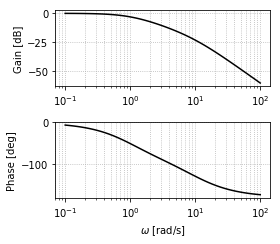

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
    
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')
ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')

fig.tight_layout()

制御対象のボード線図．
低周波ゲインが０[dB]なので，このままフィードバック系を構築しても定常偏差が残る．

### 位相遅れ補償の設計

** 定常偏差を小さくするために，位相遅れ補償から設計する **

低周波ゲインを上げるために，$\alpha=20$とする．そして，ゲインを上げる周波数は，$T_1$で決めるが，最終的なゲイン交差周波数（ゲイン交差周波数の設計値）の１０分の１程度を$1/T_1$にするために，$T_1=0.5$とする（$1/T_1=20/10=2$）．

K1= 
10 s + 20
---------
10 s + 1

-----------------------
phase at 20rad/s = -155.99666022403284


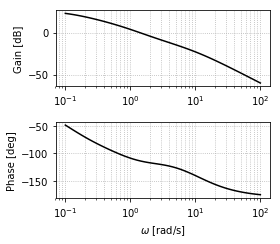

In [4]:
alpha = 20
T1 = 0.5
K1 = tf([alpha*T1, alpha], [alpha*T1, 1])
print('K1=', K1)

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 
H1 = P*K1
gain, phase, w = bode(H1, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')
ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
fig.tight_layout()

[[[mag]]], [[[phase]]], omega = freqresp(H1, [20])
#magH1at20 = mag
phaseH1at20 = phase * (180/np.pi)
print('-----------------------')
#print('gain at 20rad/s =', 20*np.log10(magH1at20))
print('phase at 20rad/s =', phaseH1at20)

最終的にゲイン補償によって，ゲイン交差周波数を設計値の20[rad/s]まで上げるが，あげてしまうと，位相余裕が60[dB]を下回る．実際， 20[rad/s]における位相は -156[deg]なので，位相余裕は 24[deg]程度になってしまう．したがって，20[rad/s]での位相を -120[deg] まであげておく．

### 位相進み補償の設計

** 位相進み補償の設計 ** 

20[rad/s]において位相を進ませる量は　60 - (180-156) = 36[deg]程度とする．

K2= 
0.09812 s + 1
-------------
0.02548 s + 1

-----------------------
gain at 20rad/s = -27.121982029204407
phase at 20rad/s = -119.99999999999999


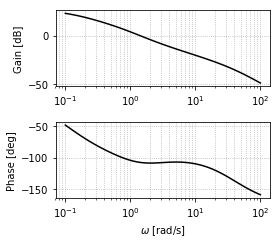

In [5]:
phim = (60- (180 + phaseH1at20 ) ) * np.pi/180
beta = (1-np.sin(phim))/(1+np.sin(phim))
T2 = 1/20/np.sqrt(beta)
K2 = tf([T2, 1],[beta*T2, 1])
print('K2=', K2)

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 
H2 = P*K1*K2
gain, phase, w = bode(H2, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')
ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')

fig.tight_layout()

[[[mag]]], [[[phase]]], omega = freqresp(H2, [20])
magH2at20 = mag
phaseH2at20 = phase * (180/np.pi)
print('-----------------------')
print('gain at 20rad/s =', 20*np.log10(magH2at20))
print('phase at 20rad/s =', phaseH2at20)

In [6]:
magH2at20

0.04404543449617801

位相進み補償により，20[rad/s]での位相が -120[deg]となっている．
あとは，ゲイン補償により，20[rad/s]のゲインを 0[dB] にすればよい．

### ゲイン補償の設計

** ゲイン補償の設計 **

20[rad/s] におけるゲインが0[dB]となるように$k = 1/magH2at20$ をゲイン補償とする．
これにより，20[rad/s]がゲイン交差周波数になり，位相余裕もPM=60[deg]となる．

k= 22.703828704125367
-----------------
(GM, PM, wpc, wgc)
(inf, 59.99999999999994, nan, 20.00000000000004)


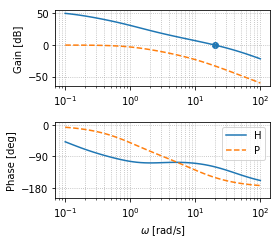

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

k = 1/magH2at20
print('k=', k)

H = P*k*K1*K2
gain, phase, w = bode(H, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), label='H')
ax[1].semilogx(w, phase*180/np.pi, label='H')

gm, pm, wpc, wgc = margin(H)
ax[0].scatter(wgc,0)

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), ls='--', label='P')
ax[1].semilogx(w, phase*180/np.pi, ls='--', label='P')

gm, pm, wcp, wgc = margin(P)
ax[0].scatter(wgc,0)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])
ax[1].legend()
fig.tight_layout()

print('-----------------')
print('(GM, PM, wpc, wgc)')
print(margin(H))

### 閉ループ系の応答

error= 0.0021974323816077446
------------------
error= 0.5
------------------


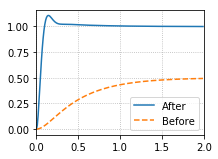

In [8]:
fig, ax = plt.subplots(figsize=(3, 2.3))

Gyr_H = feedback(H, 1)
y, t = step(Gyr_H, np.arange(0,2,0.01))

ax.plot(t,y, label='After')

e_std = 1 - dcgain(Gyr_H)
print('error=', e_std)    
print('------------------')

Gyr_P = feedback(P, 1)
y, t = step(Gyr_P, np.arange(0,2,0.01))
pltargs = {'ls': '--', 'label': 'Before'}
ax.plot(t, y, **pltargs)
    
e_std = 1 - dcgain(Gyr_P)
print('error=', e_std)    
print('------------------')

ax.set_xlim(0,2)
ax.grid(ls=':')
ax.legend()

直流ゲイン = -0.01910765674282279
------------------
直流ゲイン = -6.020599913279624
------------------


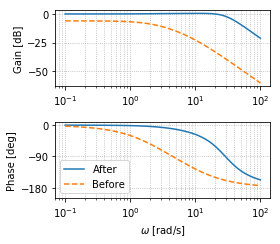

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(Gyr_H, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), label='After')
ax[1].semilogx(w, phase*180/np.pi, label='After')

print('直流ゲイン =', 20*np.log10(Gyr_H.dcgain()))    
print('------------------')


gain, phase, w = bode(Gyr_P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)

print('直流ゲイン =', 20*np.log10(Gyr_P.dcgain()))    
print('------------------')

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])
ax[1].legend()

fig.tight_layout()
# fig.savefig("loop_leadlag_fbbode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### ループ整形の例題２

$P(s) = \frac{10\omega_n}{(s^2+2\zeta\omega_n s + \omega_n^2)(0.01s+1)} $

$\zeta=0.6,~\omega_n=0.1$

に対して，以下の仕様を満たす位相進み・遅れ補償を設計せよ

（１）ゲイン交差周波数を 1 [rad/s]

（２）位相余裕を PM = 50 [deg]

（３）開ループ系の低周波ゲインを 20[dB]増加

In [10]:
omega_n = 0.1
zeta = 0.6
P1 = tf( [0,10*omega_n**2], [1, 2*zeta*omega_n, omega_n**2] )
P2 = tf( [0, 1], [0.01, 1])
P = P1*P2

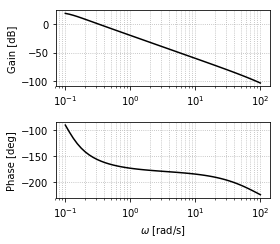

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
    
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')
ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')

fig.tight_layout()
# fig.savefig("loop_leadlag_plant.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 位相遅れ補償の設計

** 定常偏差を小さくするために，位相遅れ補償から設計する **

低周波ゲインを20[dB]上げるために，$\alpha=10$とする．そして，ゲインを上げる周波数は，$T_1$で決めるが，最終的なゲイン交差周波数（ゲイン交差周波数の設計値）の１０分の１程度を$1/T_1$にするために，$T_1=10$とする（$1/T_1=1/10=0.1$）．

K1= 
100 s + 10
----------
100 s + 1

-----------------------
phase at 1rad/s = -178.79936601847496


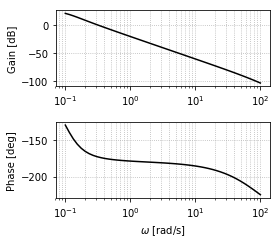

In [12]:
alpha = 10
T1 = 10
K1 = tf([alpha*T1, alpha], [alpha*T1, 1])
print('K1=', K1)

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 
H1 = P*K1
gain, phase, w = bode(H1, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')
ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
fig.tight_layout()


[[[mag]]], [[[phase]]], omega = freqresp(H1, [1])
#magH1at1 = mag
phaseH1at1 = phase * (180/np.pi)
print('-----------------------')
#print('gain at 1rad/s =', 20*np.log10(magH1at1))
print('phase at 1rad/s =', phaseH1at1)

最終的にゲイン補償によって，ゲイン交差周波数を設計値の1[rad/s]まで上げるが，あげてしまうと，位相余裕が50[dB]を下回る．実際， 1[rad/s]における位相は -178[deg]なので，位相余裕は 2[deg]程度になってしまう．したがって，1[rad/s]での位相を -130[deg] まであげておく．

### 位相進み補償の設計

** 位相進み補償の設計 ** 

1[rad/s]において位相を進ませる量は　50 - (180-178) = 48[deg]程度とする．

K2= 
 2.66 s + 1
------------
0.3759 s + 1

-----------------------
gain at 1rad/s = -11.43472408997205
phase at 1rad/s = -130.00000000000003


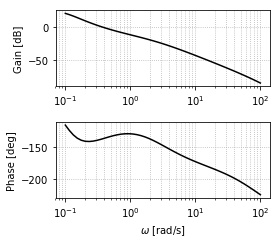

In [13]:
phim = (50- (180 + phaseH1at1 ) ) * np.pi/180
beta = (1-np.sin(phim))/(1+np.sin(phim))
T2 = 1/1/np.sqrt(beta)
K2 = tf([T2, 1],[beta*T2, 1])
print('K2=', K2)

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 
H2 = P*K1*K2
gain, phase, w = bode(H2, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')
ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')

fig.tight_layout()

[[[mag]]], [[[phase]]], omega = freqresp(H2, [1])
magH2at1 = mag
phaseH2at1 = phase * (180/np.pi)
print('-----------------------')
print('gain at 1rad/s =', 20*np.log10(magH2at1))
print('phase at 1rad/s =', phaseH2at1)

In [14]:
magH2at1

0.26807961770468264

位相進み補償により，1[rad/s]での位相が -120[deg]となっている．
あとは，ゲイン補償により，1[rad/s]のゲインを 0[dB] にすればよい．

### ゲイン補償の設計

** ゲイン補償の設計 **

1[rad/s] におけるゲインが0[dB]となるように$k = 1/magH2at1$ をゲイン補償とする．
これにより，1[rad/s]がゲイン交差周波数になり，位相余裕もPM=50[deg]となる．

k= 3.7302351016540287
-----------------
(GM, PM, wpc, wgc)
(89.63360942101347, 50.0, 15.183380339851592, 1.0000000000000007)


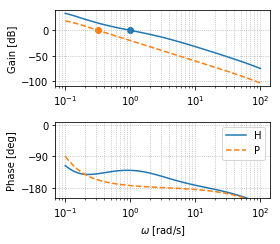

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

k = 1/magH2at1
print('k=', k)

H = P*k*K1*K2
gain, phase, w = bode(H, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), label='H')
ax[1].semilogx(w, phase*180/np.pi, label='H')

gm, pm, wpc, wgc = margin(H)
ax[0].scatter(wgc,0)

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), ls='--', label='P')
ax[1].semilogx(w, phase*180/np.pi, ls='--', label='P')

gm, pm, wcp, wgc = margin(P)
ax[0].scatter(wgc,0)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])
ax[1].legend()
fig.tight_layout()

print('-----------------')
print('(GM, PM, wpc, wgc)')
print(margin(H))

### 閉ループ系の応答

error= 0.0026736287233862788
------------------
error= 0.09090909090909083
------------------


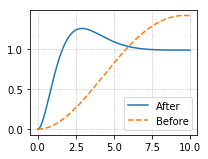

In [16]:
fig, ax = plt.subplots(figsize=(3, 2.3))

Gyr_H = feedback(H, 1)
y, t = step(Gyr_H, np.arange(0,10,0.01))

ax.plot(t,y, label='After')

e_std = 1 - dcgain(Gyr_H)
print('error=', e_std)    
print('------------------')

Gyr_P = feedback(P, 1)
y, t = step(Gyr_P, np.arange(0,10,0.01))
pltargs = {'ls': '--', 'label': 'Before'}
ax.plot(t, y, **pltargs)
    
e_std = 1 - dcgain(Gyr_P)
print('error=', e_std)    
print('------------------')

ax.legend()
ax.grid(ls=':')

直流ゲイン = -0.023253944101646613
------------------
直流ゲイン = -0.8278537031645
------------------


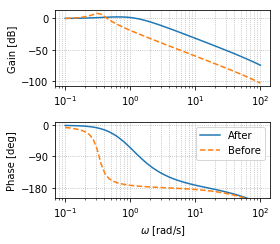

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(Gyr_H, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), label='After')
ax[1].semilogx(w, phase*180/np.pi, label='After')

print('直流ゲイン =', 20*np.log10(Gyr_H.dcgain()))    
print('------------------')


gain, phase, w = bode(Gyr_P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)

print('直流ゲイン =', 20*np.log10(Gyr_P.dcgain()))    
print('------------------')

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])
ax[1].legend()

fig.tight_layout()